In [1]:
import sys
sys.path.insert(1, r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey')
from scoring_for_donald import TileSetScorer, ScoringSubroutine

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import json
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import pandas as pd
import cv2
from csbdeep.utils import Path, normalize
from glob import glob

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [3]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [4]:
model = load_model(r'\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0')

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0\offshoot_model


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6883699162882626, nms=0.3) 



In [5]:
# load tile images and masks
pthHE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

HE_tiles = list(map(imread,HE_tiles_pths))
mask_tiles = list(map(imread,mask_tiles_pths))

HE_tiles_default = [normalize(x) for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles_default = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

HE_tiles = [x/255 for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

In [6]:
def get_predictions(model):
    mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_tiles)]

    return mask_val_pred

In [7]:
# variables for plotting and stuff
nms = [os.path.basename(file) for file in HE_tiles_pths]

taus = [0.5, 0.6, 0.7, 0.8, 0.9]

'

predictions = get_predictions(model)

scores = []

for tau in taus:
    score = TileSetScorer(nms, mask_tiles, predictions, [tau])
    scores.append(score)

results = [score.score_set() for score in scores]

100%|██████████| 36/36 [00:03<00:00, 10.64it/s]
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The

KeyboardInterrupt: 

In [ ]:
results[0].head()

,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.5,0.756306,170,16,28,0.913978,0.858586,0.794393,0.885417,0.825047,0.730511
1,monkey_fetus_40_0273_bone.tif,0.5,0.721545,40,6,16,0.869565,0.714286,0.645161,0.784314,0.789210,0.618988
2,monkey_fetus_40_0281_eyes2.tif,0.5,0.691126,170,15,71,0.918919,0.705394,0.664062,0.798122,0.764678,0.610306
3,monkey_fetus_40_0308_liver1.tif,0.5,0.813713,144,6,11,0.960000,0.929032,0.894410,0.944262,0.844399,0.797334
4,monkey_fetus_40_0323_ears1.tif,0.5,0.690478,180,54,52,0.769231,0.775862,0.629371,0.772532,0.732129,0.565593


In [ ]:
def find_first_unique_indices(lst):
    unique_indices = {}
    result = []

    for i, value in enumerate(lst):
        if value not in unique_indices:
            unique_indices[value] = i

    for value in lst:
        result.append(unique_indices[value])

    return result

In [ ]:
def get_f1(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    avg_precision = tp / (tp + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, avg_precision, f1

In [ ]:
def get_organ_f1(result):
    names = result['Image']

    names = [name.split(".")[0][21:] for name in names]

    for i in range(len(names)):
        #if len(names[i]) > 6:
        names[i] = names[i][:2]

    result_list = find_first_unique_indices(names)

    f1_scores = result['F1 Score']

    seen = []
    names = []

    raw_vals = result[['Image', 'TP', 'FP', 'FN', 'Avg Precision']]

    TPs = [0 for _ in range(len(raw_vals))]
    FPs = [0 for _ in range(len(raw_vals))]
    FNs = [0 for _ in range(len(raw_vals))]
    APs = [0 for _ in range(len(raw_vals))]

    for i in range(len(raw_vals)):
        row = raw_vals.iloc[i]
        num = result_list[i]
        if num not in seen:
            names.append(raw_vals['Image'][i])
            seen.append(num)

        TPs[num] += row['TP']
        FPs[num] += row['FP']
        FNs[num] += row['FN']
        APs[num] += row['Avg Precision']

    organ_names = []
    for i in range(len(names)):
        nm = names[i][21:-4]
        if nm[-1] == '1':
            nm = nm[:-1]
        organ_names.append(nm)

    TPs = [val for val in TPs if val != 0]
    FPs = [val for val in FPs if val != 0]
    FNs = [val for val in FNs if val != 0]
    APs = [val for val in APs if val != 0]

    if [len(organ_names), len(TPs), len(FPs), len(FNs)] != [len(organ_names), len(organ_names), len(organ_names), len(organ_names)]:
        print('skipped')
        return 0

    new_df = pd.DataFrame({'Organ': organ_names, 'TP': TPs, 'FP': FPs, 'FN': FNs, 'AP': APs})

    precisions = []
    recalls = []
    f1s = []
    APs = []

    for i in range(len(new_df)):
        row = new_df.iloc[i]

        tp = row['TP']
        fp = row['FP']
        fn = row['FN']

        precision, recall, avg_precision, f1 = get_f1(tp, fp, fn)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        APs.append(avg_precision)

    new_df['Recall'] = recalls
    new_df['Precision'] = precisions
    new_df['F1'] = f1s
    new_df['AP'] = APs

    return new_df

In [ ]:
dfs = []
for result in results:
    df = get_organ_f1(result)
    dfs.append(df)

In [ ]:
dfs[0].head()

,Organ,TP,FP,FN,AP,Recall,Precision,F1
0,eyes,340,31,99,0.723404,0.774487,0.916442,0.839506
1,bone,117,11,49,0.661017,0.704819,0.914062,0.795918
2,liver,293,26,79,0.736181,0.787634,0.918495,0.848046
3,ears,274,70,106,0.608889,0.721053,0.796512,0.756906
4,brain,869,96,252,0.714051,0.775201,0.900518,0.833174


In [ ]:
def bulk_f1(df):    
    tp = 0
    fp = 0
    fn = 0

    for i in range(len(df)):
        row = df.iloc[i]

        tp += row['TP']
        fp += row['FP']
        fn += row['FN']

    #print(tp)
    #print(fp)
    #print(fn)

    precision, recall, avg_precision, f1 = get_f1(tp, fp, fn)

    return f1

In [ ]:
def mean_avg_precision(df):    
    MAP = 0

    for i in range(len(df)):
        row = df.iloc[i]

        MAP += row['AP']

    MAP = MAP/len(df)

    return MAP

In [ ]:
f1s = []
for df in dfs:
    f1 = bulk_f1(df)
    f1s.append(f1)

In [ ]:
mAPs = []
for df in dfs:
    mAP = mean_avg_precision(df)
    mAPs.append(mAP)

In [ ]:
print(taus)
print(mAPs)

[0.5, 0.6, 0.7, 0.8, 0.9]
[0.6622550218559431, 0.5911165634917219, 0.4679371945161191, 0.2818643935075125, 0.040305406398221645]


In [ ]:
print(taus)
print(f1s)

[0.5, 0.6, 0.7, 0.8, 0.9]
[0.7909595431512908, 0.7355046240450342, 0.6261862634711276, 0.42355022922866564, 0.07431834633636289]


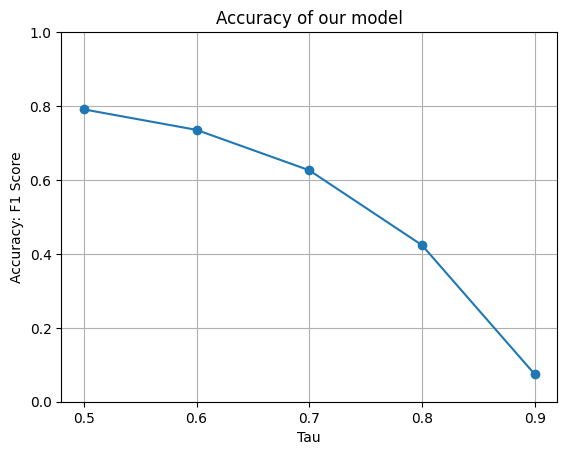

In [ ]:
plt.plot(taus, f1s, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: F1 Score')
plt.title('Accuracy of our model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()

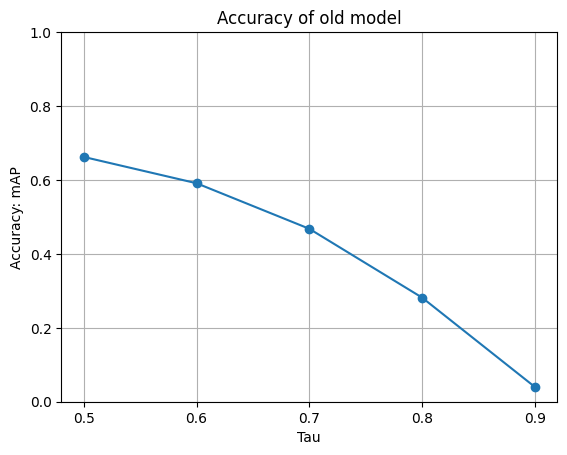

In [ ]:
plt.plot(taus, mAPs, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: mAP')
plt.title('Accuracy of old model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()

In [ ]:
import numpy as np
from scipy import integrate

area_under_curve = integrate.trapz(mAPs, taus)

print(f"Area under the curve: {area_under_curve}")

Area under the curve: 0.1692198365642436


In [ ]:
np.mean(mAPs)

0.4086957159539037